# Every Layer, Everywhere, All at Once - Starter Notebook

Welcome to Xeek's "Every Layer, Everywhere, All at Once: Segmenting Subsurface Data Challenge," which challenges you to use  Meta's Segment Anything Model (SAM) to interpret 3D seismic data.  SAM has been used for numerous use cases since its release, and we are looking for another case here.  

We are supplying you with several files for this starter notebook to help you get started with this challenge.

- src/dataset.py - module with definition of VolumeDataset, an interface for easy building torch Datasets on seismic data.
- src/train.py - example module for training initial segmentation model.
- src/utils.py - utility functions, containing loss functions used for training of initial segmentation.
- requirements.txt - libraries required for an initail run.
- config.yaml - hyperparameters for an initial segmentation model.

### Two Considerations for the Participant
1. This Starter Notebook was designed to predict only a limited number of segments per seismic volume and wasn't used to generate the sample submission.  You must experiment with this starter code to fully interpret all the segments. 
2. The submission file naming convention must be used for the scoring algorithm to work correctly. For example, predictions for 'test_vol_1.npy', 'test_vol_2.npy'... 'test_vol_50.npy' must be named as 'sub_vol_1.npy', 'sub_vol_2.npy'... 'sub_vol_50.npy' files, respectively. The Data Tab has a sample submission file for the Test Data set.  

## Background
Seismic data is one of the most complex and fascinating sources of evidence that Geophysists use to understand how the Earth has developed through time.  We will continue exploring this rich area of study with further Xeek challenges.  Still, for a quick analogy to get you going, seismic data can be considered a very large-scale version of an echocardiogram.  A source creates energy waves that move through a medium, and changes in that medium create reflections that return to a receiver.  In the case of an echocardiogram, the density difference between the heart muscle and the four chambers creates a reflection that allows a doctor to view the shape and condition of the heart.  For seismic, these reflections are different layers of the Earth, but at a grander scale, think The Grand Canyon.  Seismic reflections can tell Geophysicists about the type of rock, the fluids in the rock, and key out the history of how this part of the Earth came to be.  Geophysicists need to map each reflector in a seismic volume to fully understand this wealth of data, which can be a laborious and often incomplete task.  Speeding up this mapping process would enable Geophysicists to do more analysis of the seismic data to build better and new ideas about what could be happening there.

## Data

Training dataset consists of seismic data and the corresponding labels. For example, 'horizon_labels_block-10_vol_69764103.npy' array contains labels for 'seismic_block-10_vol_69764103.npy' data array. Each block is one-channel 300x300x100 (LxWxH) cuboid

Train and test datasets can be found in data/train and data/test catalogs, respectively. Small representative sample of data is also available in data/example catalog and will be used to walk you through this starter notebook.

Here is an example how one 'seismic data & labels' pair can be loaded:

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 6.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.9/377.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Using cached notebook_shim-0.2.3-py3-none-any.whl (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 3.6 MB/s eta 0:00:00
  Using cached jupyter_server_terminals-0.4.4-py3-none-any.whl (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.8 MB/s eta 0:00:00
  Using cached Send2Trash-1.8.2-py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.6/256.6 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.0 MB/s eta 0:00:00
  Using cached jupyter_lsp-2.2.0-py3-none-any

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load and explore seismic data
block_n = 10
vol_n = 69764103

vol_path = f'data/example/train/{vol_n}/seismic_block-{block_n}_vol_{vol_n}.npy'
vol = np.load(vol_path, allow_pickle=True)

print('Seismic volume shape', vol.shape)

Seismic volume shape (300, 300, 100)


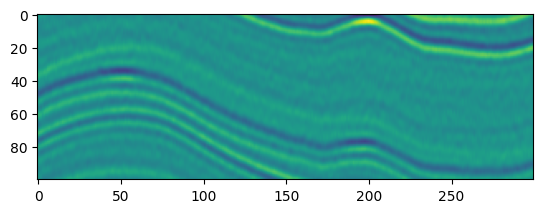

In [3]:
# visualization of one slice of seismic data within example cuboid. Transposition is applied to achieve proper (physical) orientation of the image
plt.imshow(vol[80,:,:].T)

In [4]:
# load and explore labels
label_path = f'data/example/train/{vol_n}/horizon_labels_block-{block_n}_vol_{vol_n}.npy'
labels = np.load(label_path, allow_pickle=True)
print('Labels volume shape', labels.shape)

Labels volume shape (300, 300, 100)


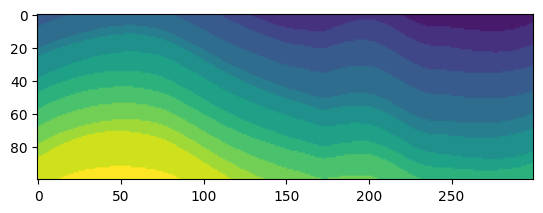

In [5]:
# visualization of one slice of labels within example cuboid
plt.imshow(labels[80,:,:].T)

## Segmentation pipeline
Segment Anything Model was originally trained to optimize performance on natural images, which are very differenct from seisimc data. You are free to use any approach to improve it. Here we propose solution utilizing U-Net to generate segments that can be then fed into SAM query. We encourage you to experiment wtih different pipelines, but keep in mind that you're required to use Meta's Segment Anything Model in some part of your process

### U-Net training
As a first step we attempt to train U-Net model based on training data

In [7]:
import sys
sys.path.append('./src')
import yaml
from time import strftime, gmtime
import os
from train import SegmentationModule, ModelCheckpoint
import pytorch_lightning as pl
from utils import multiclass_iou_dice_score

/Users/Mike.McIntire/mikes_sandbox/starter_notebook/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Mike.McIntire/mikes_sandbox/starter_notebook/.conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Mike.McIntire/mikes_sandbox/starter_notebook/.conda/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Users/Mike.McIntire/mikes_sandbox/starter_notebook/.conda/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F008E7E7-AB21-3358-8168-A868137DB0

In [10]:
## recieving a SSL: CERTIFICATE_VERIFY_FAILED error? uncomment this code and run
# !pip install --upgrade certifi
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
config_path = 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = SegmentationModule(config, data_path_train = 'data/example/train/', data_path_val= 'data/example/test/')

time = strftime("%Y-%m-%d_%H:%M:%S", gmtime())

checkpoint_dirpath = '../starter_notebook/checkpoints/'
chkptExist = os.path.exists(checkpoint_dirpath)
if not chkptExist:
    os.makedirs(checkpoint_dirpath)

model_dirpath = os.path.join('../starter_notebook/checkpoints/', config['name']+'_'+time)
mdlExist = os.path.exists(model_dirpath)

if not mdlExist:
    os.mkdir(model_dirpath)

checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dirpath, **config['model_checkpoint'])

trainer = pl.Trainer(
            logger=model.logger,
            precision=32,
            accelerator="auto", 
            devices=1,
            max_epochs=config['epochs'],
            callbacks=[checkpoint_callback],
            log_every_n_steps=1
        )

trainer.fit(model)


### U-Net inference


In [ ]:
import torch

model = SegmentationModule(config, mode='val', data_path_val= 'data/example/test/')
checkpoint_weights = 'checkpoints/example_2023-11-10_16:51:42/epoch=0-val_loss=0.144-val_metric=0.354.ckpt'#checkpoint_weights = # path to your checkpoint weights, e.g. 'checkpoints/example_2023-10-10_16:51:42/latest.ckpt
state_dict = torch.load(checkpoint_weights)['state_dict']
fixed_state_dict = {key.replace('model.', ''): value for key, value in state_dict.items()}

model.load_state_dict(fixed_state_dict)
model = model.cuda().eval()
# model = model.eval()

In [ ]:
# check results on sample image
index = 5
img, lb = model.val_data[index]

im = torch.unsqueeze(img, 0)
lb = torch.unsqueeze(lb, 0)


image = im.cuda()

prediction = model(image)

# check DICE score 
print(f"Sample {index} DICE score: {multiclass_iou_dice_score(prediction.detach().cpu(), lb)}")

# Apply softmax + squeeze
prediction = prediction.log_softmax(dim=1).exp()
prediction = prediction.squeeze(0).detach().cpu().numpy()
# Get mask id from prediction array
prediction = np.array(prediction, dtype='float32')
new_im = np.argmax(prediction, axis=0)

# visualize results next to preprocessed image and ground-truth labels
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(1, 3, tight_layout=True)
axs[0].imshow(img[0])
axs[0].title.set_text('Preprocessed Image')
axs[1].imshow(lb[0])
axs[1].title.set_text('Labels')
axs[2].imshow(new_im)
axs[2].title.set_text('Predicted labels')

## SAM inference using initial segments
Once we obtained initial segmentation from U-Net model, we can now use them to refine SAM query. 

In [ ]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
sam_checkpoint = "YOUR_CHECKPOINT.pth" # place path to SAM checkpoint here
model_type = "vit_h" # set model type according to ussed checkpoint

device = "cuda" # GPU is used by default - change this settings if you don't have CUDA acceleratr available
torch.cuda.empty_cache()
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

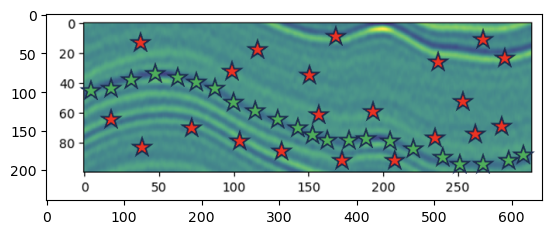

In [8]:
# SAM model accepts multiple points in query to provide better segmentation. We can leverage any other segmentation model to generate initial segment boundries:
example_query = plt.imread('sam_query_example.png')
plt.imshow(example_query)

# green stars indicate positive points ("1"), red stars - negative points ("0")

In [ ]:
def segment_sam(predictior: SamPredictor, image: np.ndarray, segments: np.ndarray) -> np.ndarray:
    """
    You can use this function blueprint to sequentially query SAM using unsupervised segmentation results
    :param predictor: valid instance of SamPredictor class
    :param image: image that is going to be segmented
    :param segments: array of segment labels from U-Net prediction 
    
    :returns: array of segment labels, with same size as input image
    """
    result = np.zeros(segments.shape)
    for seg in np.unique(segments):
        points: np.ndarray = ... # array of query points to query
        point_labels: np.ndarray = ... # U-Net based labels for selected points, either 0 or 1  
            
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=points,
            point_labels=labels,
            multimask_output=False
                )
        for k in range(segments.shape[0]):
            for l in range(segments.shape[1]):
                if masks[0][k, l] == 1:
                    result[k, l] = segment
    return result

## Solution
Your code should provide methods for loading the data, training, prediction and saving the results in expected format. You can use provided template to organize your solution


In [6]:
from abc import ABCMeta, abstractmethod

class SegmentationPipeline(metaclass = ABCMeta):
    """
    Template for your segmentation pipeline interface. You can build your solution based on this abstract class
    """
    @abstractmethod
    def load_data(self, path: str, *args, **kwargs):
        ...
    
    @abstractmethod
    def preprocess(self, *args, **kwargs):
        ...
    
    @abstractmethod
    def train(self, *args, **kwargs):
        ...
    
    @abstractmethod
    def predict(self, *args, **kwargs):
        ...
    
    @abstractmethod
    def save_results(self, path: str, *args, **kwargs):
        ...
    

## Evaluation

To evaluate the performance of your solution you will need to submit segmentation masks for the 50 test volumes, found on the Data Tab. For this challenge, a Dice Coefficient is the primary metric to assess the accuracy of your model. You can learn more about Dice Coefficient scoring here https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient. 

Please note that the submission file naming convention must be used for the scoring algorithm to work correctly. For example, predictions for 'test_vol_1.npy', 'test_vol_2.npy'... 'test_vol_50.npy' must be named as 'sub_vol_1.npy', 'sub_vol_2.npy'... 'sub_vol_50.npy' files, respectively. The Data Tab has a sample submission file for the Test Data set. Each submission file must contain segmentation mask for whole cuboid - make sure that dimensions of your prediction match the shape of test volume.

This challenge is unique because of the data's 3D nature, so the scoring algorithm has several evaluation steps:
1.  A 2D slice is selected from a submitted volume; each segment in the slice is compared with its ground truth segment equivalent (see Table 1).
2.  The false positives, true positives, and false negatives are calculated per segment for that slice.
3.  Steps 1 and 2 are repeated for each slice in the submitted volume.
4.  The false positives, true positives, and false negatives are summed for each segment in the volume, and then the Dice coefficient is calculated.
5.  The Dice coefficient for each segment is averaged together, providing a final score for the volume. 
6.  Steps 1 through 5 are repeated for each of the 50 test volumes.  The average Dice coefficient of all 50 test volumes is then calculated for the Predictive Leaderboard score.
